In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.filters import gaussian, sobel, sobel_h, sobel_v
# from skimage.morphology import skeletonize
from skimage.transform import hough_line, hough_line_peaks
import numpy as np

In [22]:
CALIBRATION_LEFT_FILEPATH = '../../data/2025-06-10-40uL_250um/calibration_left.tif'
CALIBRATION_TEST_LEFT_FILEPATH = '../../data/2025-06-13/calibration_left.tif'
CALIBRATION_TEST_RIGHT_FILEPATH = '../../data/2025-06-13/calibration_right.tif'
TEST_IMAGE = '../../data/toys/line_outline.png'

GRID_DIMENSIONS = (4,5)

BINARY_THRESHOLD = 3/10

ORTHOG_ERROR = 2*(np.pi) / 90 # ALLOWED ORTHOGONAL ERROR

NUM_LINES = GRID_DIMENSIONS[0] + GRID_DIMENSIONS[1] + 2
# im = plt.imread(CALIBRATION_LEFT_FILEPATH)[:,:,0]
im = plt.imread(CALIBRATION_TEST_LEFT_FILEPATH)[:,:,0]
# im = plt.imread(CALIBRATION_TEST_RIGHT_FILEPATH)[:,:,0]


# im = plt.imread(TEST_IMAGE)[:,:,0]


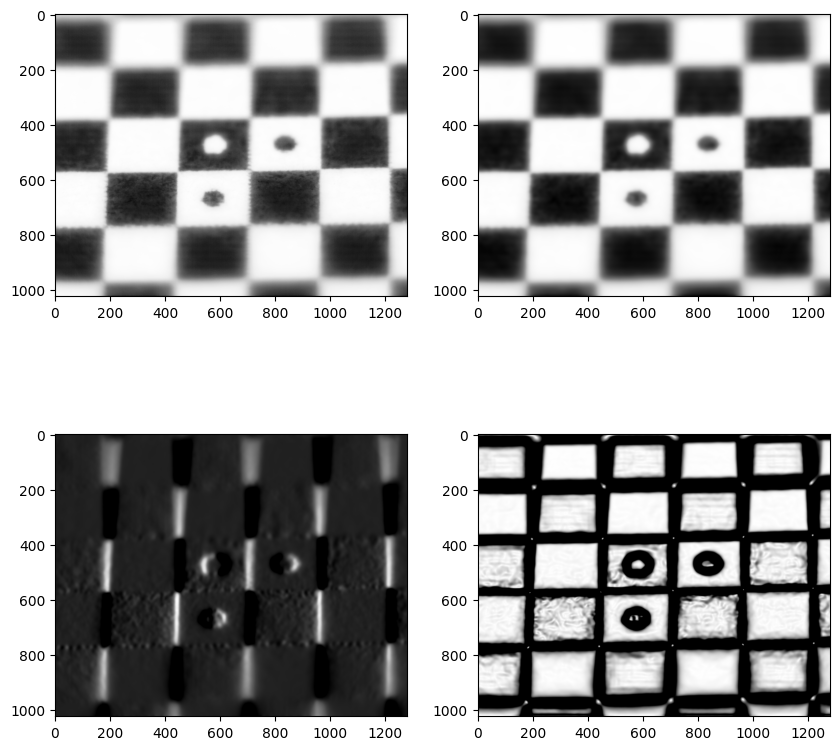

In [23]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(im,cmap='Greys')
plt.subplot(2,2,2)
im_blur = gaussian(im,sigma=5)
plt.imshow(im_blur,cmap='Greys')
plt.subplot(2,2,3)
plt.imshow(sobel_v(im_blur)*100,vmax=1,cmap='Greys')
plt.subplot(2,2,4)
plt.imshow(sobel(im_blur)*100,vmax=1,cmap='Greys')

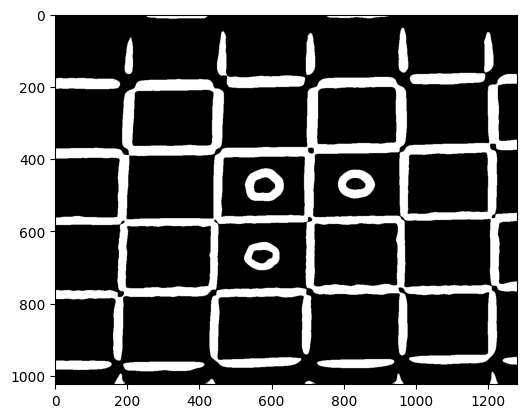

In [24]:
# from skimage.morphology import skeletonize

im_sobel = sobel(im_blur)
# im_sobel = 255 - im_sobel

threshold = im_sobel.max() * BINARY_THRESHOLD


thresholded = im_sobel > threshold

# SOBEL SPACE MAX VALUE DIVIDED BY CONSTANT S.T. EACH IMAGE THRESHOLD DEPENDENT ON CONDITIONS

# thresholded = np.invert(thresholded)
# skeleton = skeletonize(thresholded)
plt.imshow(thresholded,cmap=cm.grey)

# plt.imshow(im_sobel,cmap=cm.grey)

4.974125234073121 569.9782961465777
6.876248136289738 393.93999189161815
13.490710176020222 772.8822683558905
3.525386100331287 201.96923442159104
17.016096276351508 974.8515027774815
1201.954231523134 -10.489295669045498
961.9633699877328 8.394927149435725
463.84099878865857 12.146104014853142
212.8702461550674 7.4335927976327065
702.9732319141124 6.134754455356876


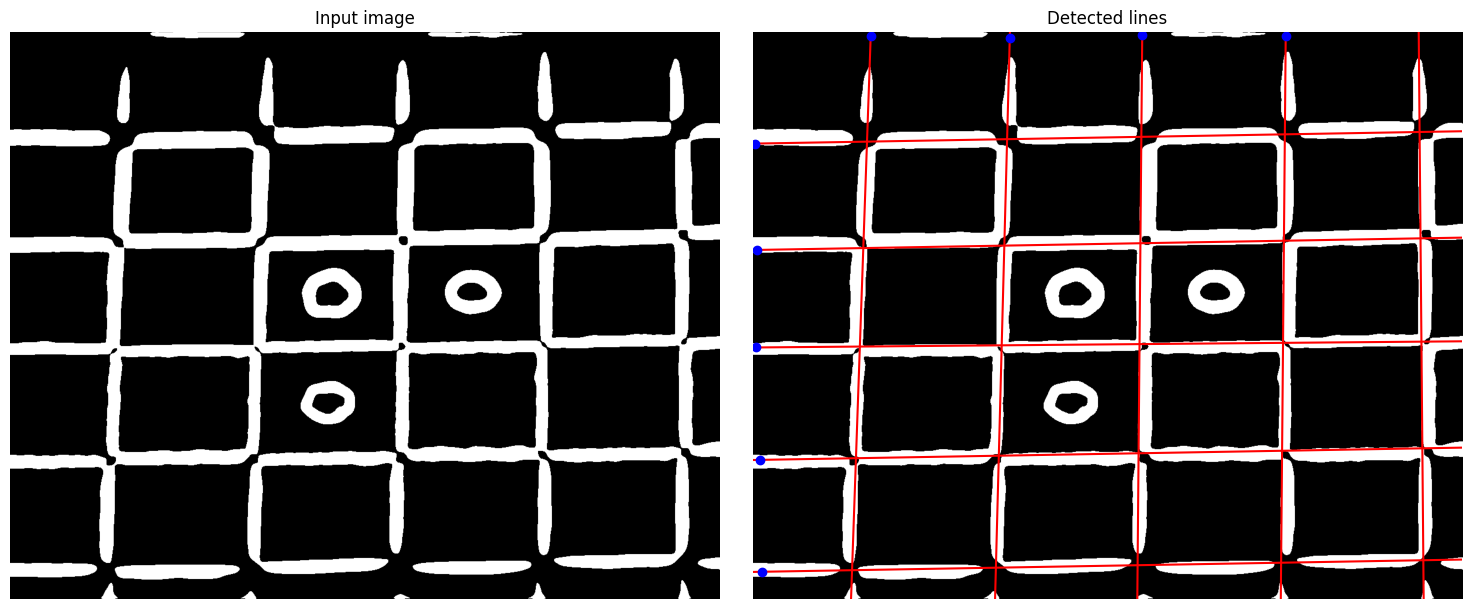

In [25]:
tested_angles = np.linspace(-(np.pi / 2)+(np.pi/2), (np.pi / 2)+(np.pi/2), 360, endpoint=False)

h, theta, d = hough_line(thresholded, theta=tested_angles)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()
ax[0].imshow(thresholded, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(thresholded, cmap=cm.gray)
ax[1].set_ylim((thresholded.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')

line_r0s = []
line_angles = []

for _, angle, dist in zip(*hough_line_peaks(h, theta, d, num_peaks=NUM_LINES, min_distance=100)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    line_r0s.append((x0,y0))
    ax[1].axline((x0, y0), slope=np.tan(angle + np.pi / 2),c='red')
    ax[1].plot(x0,y0,'bo')
    line_angles.append(np.tan(angle + np.pi / 2))
    print(x0,y0)

plt.tight_layout()
plt.show()


In [26]:
def line_intersection(x1, y1, angle1, x2, y2, angle2):
    # Direction vectors
    dx1, dy1 = np.cos(angle1 + np.pi/2), np.sin(angle1 + np.pi/2)
    dx2, dy2 = np.cos(angle2 + np.pi/2), np.sin(angle2 + np.pi/2)
    
    # Check if lines are parallel
    det = dx1 * dy2 - dx2 * dy1
    if abs(det) < 1e-10:
        return None
    
    # Solve for intersection
    # Line 1: (x1, y1) + t1 * (dx1, dy1)
    # Line 2: (x2, y2) + t2 * (dx2, dy2)
    # Set equal and solve for t1
    
    t1 = ((x2 - x1) * dy2 - (y2 - y1) * dx2) / det
    
    x_intersect = x1 + t1 * dx1
    y_intersect = y1 + t1 * dy1
    
    return (x_intersect, y_intersect)

def find_all_intersections(points_angles):
    intersections = []
    n = len(points_angles)
    
    for i in range(n):
        for j in range(i + 1, n):
            x1, y1, angle1 = points_angles[i]
            x2, y2, angle2 = points_angles[j]
            
            intersection = line_intersection(x1, y1, angle1, x2, y2, angle2)
            
            if intersection is not None:
                intersections.append({
                    'point': intersection,
                    'line1_idx': i,
                    'line2_idx': j
                })
    
    return intersections

def hough_intersections(hough_results, image_shape=None, filter_bounds=True):
    _, angles, distances = hough_results
    
    points_angles = []
    for angle, dist in zip(angles, distances):
        # Point on line closest to origin
        x0 = dist * np.cos(angle)
        y0 = dist * np.sin(angle)
        points_angles.append((x0, y0, angle))
    
    intersections = find_all_intersections(points_angles)
    
    if filter_bounds and image_shape is not None:
        height, width = image_shape
        margin = 10  # Allow small margin outside image
        filtered = []
        for inter in intersections:
            x, y = inter['point']
            if -margin <= x <= width + margin and -margin <= y <= height + margin:
                filtered.append(inter)
        intersections = filtered
    
    return intersections

Found 25 intersections
580 473
834 473
574 666


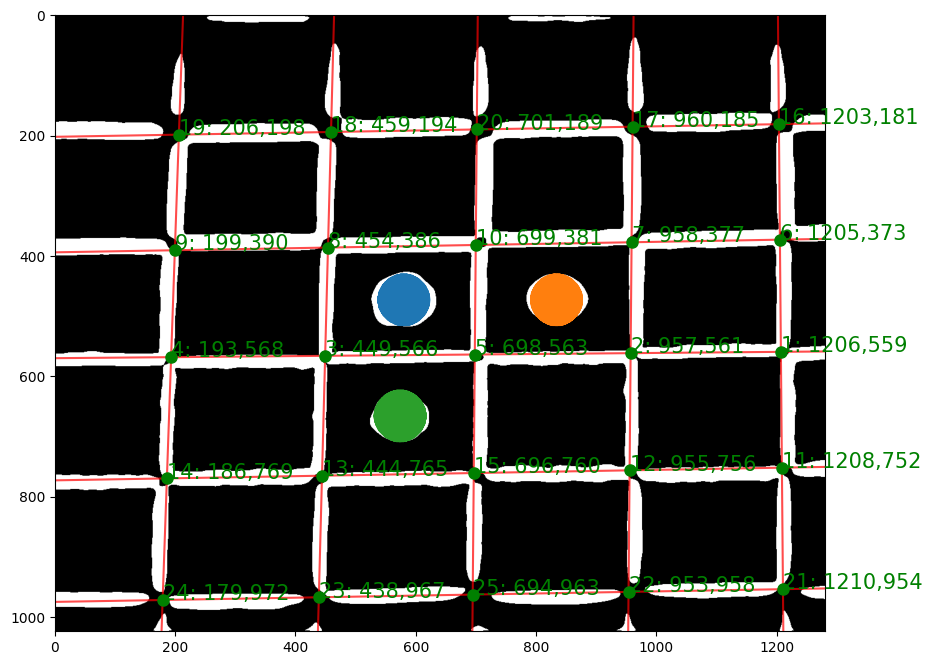

In [ ]:
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
shape = thresholded.shape
rad_min = int(min(shape) / (4*(min(GRID_DIMENSIONS)+2)))
rad_max = int(max(shape) / (4*(max(GRID_DIMENSIONS) + 2)))

hough_radii = np.arange(rad_min, rad_max, 10)
hough_res = hough_circle(thresholded, hough_radii)

accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=3, min_xdistance = 100, min_ydistance = 100)

peaks = hough_line_peaks(h, theta, d, num_peaks=NUM_LINES, min_distance=100)
intersections = hough_intersections(peaks, thresholded.shape)
print(f"Found {len(intersections)} intersections")
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(thresholded, cmap='gray')

for _, angle, dist in zip(*peaks):
    x0, y0 = dist * np.array([np.cos(angle), np.sin(angle)])
    ax.axline((x0, y0), slope=np.tan(angle + np.pi/2), color='red', alpha=0.7)

k = 0

for inter in intersections:
    x, y = inter['point']
    k = k+1
    ax.plot(x, y, 'go', markersize=8)
    ax.text(x,y,str(k) + ': ' + str(int(x)) +','+ str(int(y)),c = 'g',fontsize = 15)

for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=thresholded.shape)
    ax.plot(circx, circy)

    print(center_x,center_y)


ax.set_xlim(0, thresholded.shape[1])
ax.set_ylim(thresholded.shape[0], 0)
plt.show()



In [ ]:
points = np.array

for inter in intersections:
    x,y = inter['point']
    print(x,y)

955.997638895874 691.9999999999999
1254.0 691.9999999999999
75.9134414971561 692.0
367.16484351714774 692.0
666.2554130778976 691.9999999999999
957.8444452325004 480.3769548357248
1254.0 482.9614652076797
91.24040459937831 472.814215946182
376.62596298059225 475.3047379835668
673.7320356124691 477.8975433992568
953.9611369357241 925.360010599281
1254.0 927.9784100893327
60.140766689533756 917.5597583994553
357.2035039657633 920.1521856332259
658.1964359178511 922.7789111563247
959.7171184884877 265.78985429887115
1254.0 270.92658110291745
106.7580604486192 250.9013985596742
386.2106522678247 255.77926169423702
681.3087015942328 260.9302173054198
